In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
import numpyro.distributions as dist
import blackjax

/Users/gabestechschulte/miniforge3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng_key = jax.random.PRNGKey(44)
#k1, k2, k3 = jax.random.split(rng_key, 3)

In [3]:
with numpyro.handlers.seed(rng_seed=7):
    y = numpyro.sample("y", dist.Normal().expand([50]))
    x = numpyro.sample("x", dist.Normal().expand([50]))
    x = (x - jnp.mean(x)) / jnp.std(x)
    y = (y - jnp.mean(y)) / jnp.std(y)

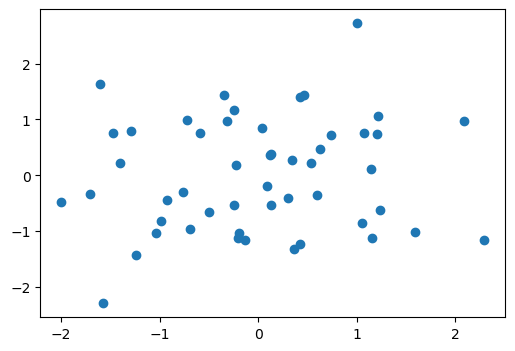

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(x, y);

In [ ]:
x = jnp.arange(-3, 3, 0.1)
y = jnp.arange(-3, 3, 0.1)
X, Y = jnp.meshgrid(x, y)
Z = jnp.dstack(X, Y)

In [6]:
def target_density(q):
    
    # q = list of params of d-dimension
    mu_y = q[0]
    mu_x = q[1]

    # priors
    log_probs_mu_x = dist.Normal(loc=0, scale=1).log_prob(mu_x)
    log_probs_mu_y = dist.Normal(loc=0, scale=1).log_prob(mu_y)

    # likelihood
    log_prob_y = jnp.sum(dist.Normal(loc=mu_y, scale=1).log_prob(y))
    log_prob_x = jnp.sum(dist.Normal(loc=mu_x, scale=1).log_prob(x))

    # posterior
    posterior = log_prob_x + log_prob_y + log_probs_mu_x + log_probs_mu_y

    return -posterior

In [7]:
grad_target_density = jax.grad(target_density)

In [8]:
def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(jax.random.fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = jnp.full((L + 1, q.shape[0]), jnp.nan)
    ptraj = qtraj
    intra_proposal_energy = jnp.full((L + 1, 1), jnp.nan)
    qtraj = qtraj.at[0].set(current_q)
    ptraj = ptraj.at[0].set(p)
    intra_proposal_energy.at[0].set(0)

    print("---- start of trajectory ----")
    print(f"p = {p}, q = {q}")
    
    intra = []
    # Alternate full steps for position and momentum
    print(f"---- intra-trajectory points ----")
    for i in range(L):
        runif = dist.Uniform().sample(jax.random.fold_in(rng, 1))
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ptraj.at[i + 1].set(p)

        qtraj = qtraj.at[i + 1].set(q)

        intra_proposal_p = jnp.sum(p ** 2) / 2
        intra_proposal_q = U(q)
        intra.append(intra_proposal_q)
        #intra_proposal_energy.at[i + 1].set(intra_proposal_q)
        #print(f"intra-traj. energy: q = {intra_proposal_q}")


        print(f"p = {p}, q = {q}, intra-q-energy = {intra_proposal_q}")

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ptraj.at[L].set(p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    intra.append(current_U)
    current_K = jnp.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = jnp.sum(p ** 2) / 2

    print("---- end of trajectory ----")
    print(f"p = {p}, q = {q}")

    print("---- end of traj. kinetic and potential energies ----")
    print(f"p = {proposed_K}, q = {proposed_U}")

    multinomial_probs = jax.nn.softmax(jnp.array(intra))
    print("---- multinomial probs. ----")
    print(multinomial_probs)


    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(jax.random.fold_in(rng, 1))
    if runif < jnp.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        print("** proposed new q **")
        print(f"q = {new_q}")
        accept = 1
    else:
        new_q = current_q  # reject
    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }

In [20]:
probs = jnp.array([8.0060475e-03, 8.2456870e-07, 1.6283137e-12, 1.0254538e-19, 3.6660739e-28,
 1.3780452e-37, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9199307e-01])

In [21]:
dist.Multinomial(total_count=10, probs=probs).sample(rng_key)

Array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10], dtype=int32)

In [11]:
Q = {}
Q["q"] = jnp.array([-0.1, 0.2])
pr = 0.31
step = 0.03
L = 9  # 0.03/28 for U-turns --- 11 for working example
n_samples = 1

for i in range(n_samples):
    Q = HMC2(
        target_density, 
        grad_target_density, 
        step, 
        L, 
        Q["q"], 
        jax.random.fold_in(jax.random.PRNGKey(0), i)
    )

---- start of trajectory ----
p = [ 0.9702661 -1.4634401], q = [-0.1  0.2]
---- intra-trajectory points ----
p = [ 1.0099937 -1.839102 ], q = [-0.07089202  0.1560968 ], intra-q-energy = 293.36224365234375
p = [ 0.9942725 -2.1137977], q = [-0.04059221  0.10092375], intra-q-energy = 292.7521057128906
p = [ 0.9239656 -2.2724457], q = [-0.01076404  0.03750982], intra-q-energy = 292.3368835449219
p = [ 0.80293316 -2.3063364 ], q = [ 0.01695493 -0.03066355], intra-q-energy = 292.2064514160156
p = [ 0.63781965 -2.2136092 ], q = [ 0.04104292 -0.09985364], intra-q-energy = 292.38916015625
p = [ 0.43768972 -1.999355  ], q = [ 0.06017751 -0.16626191], intra-q-energy = 292.8454895019531
p = [ 0.21353072 -1.6753361 ], q = [ 0.0733082  -0.22624256], intra-q-energy = 293.4764404296875
p = [-0.02235107 -1.2593414 ], q = [ 0.07971412 -0.27650264], intra-q-energy = 294.14544677734375
p = [-0.02235107 -1.2593414 ], q = [ 0.07904359 -0.3142829 ], intra-q-energy = 294.70758056640625
---- end of trajectory 

## Blackjax

In [12]:
import numpy as np

inv_mass_matrix = np.array([1, 1])
num_integration_steps = 60
step_size = 1e-3

# so we don't need to specify the step size and mass matrix
warmup = blackjax.window_adaptation(blackjax.nuts, target_density)

initial_pos = jnp.array([0., 0.])
(state, params), _ = warmup.run(rng_key, initial_pos)

#hmc = blackjax.hmc(target_density, step_size, inv_mass_matrix, num_integration_steps)

# initialize the state
#initial_state = hmc.init(initial_pos)

# obtain HMC kernel
#hmc_kernel = jax.jit(hmc.step)

ValueError: too many values to unpack (expected 2)

In [29]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [30]:
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 1000)

In [31]:
x_loc = states[0][:, 0]
y_loc = states[0][:, 1]

In [ ]:
sample_len = jnp.arange(0, 1000)
plt.plot(sample_len, x_loc)

In [14]:
# HMC
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
hmc = blackjax.hmc(target_density, step_size, inverse_mass_matrix, 1e-2)

# initialize the state
initial_pos = jnp.array([0., 0.])
state = hmc.init(initial_pos)

# iterate
samples = []
step = jax.jit(hmc.step)
for _ in range(1000):
    _, rng_key = jax.random.split(rng_key)
    state, _ = step(rng_key, state)
    samples.append(state.position)

samples = jnp.array(samples)

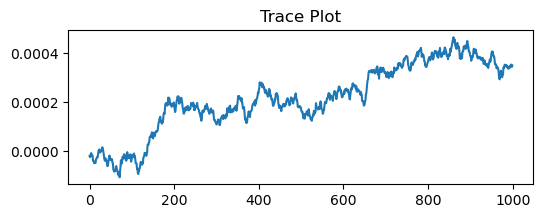

In [17]:
sample_len = jnp.arange(0, 1000)
plt.figure(figsize=(6, 2))
plt.plot(sample_len, samples[:, 0])
plt.title('Trace Plot');

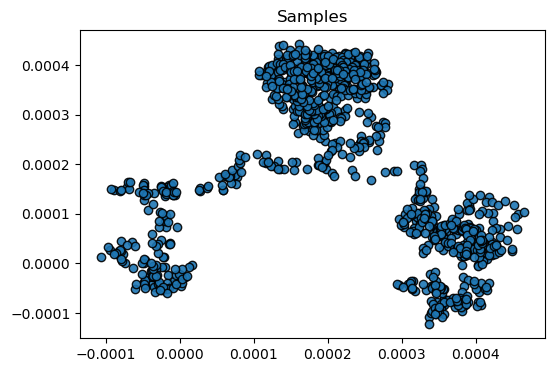

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(samples[:, 0], samples[:, 1], edgecolors='black', alpha=0.9)
plt.title('Samples');

## Eight Schools

In [13]:
import numpy as np

In [14]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [15]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam


def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    with numpyro.plate("J", J):
        with numpyro.handlers.reparam(config={"theta": TransformReparam()}):
            theta = numpyro.sample(
                "theta",
                dist.TransformedDistribution(
                    dist.Normal(0.0, 1.0), dist.transforms.AffineTransform(mu, tau)
                ),
            )
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

In [17]:
from numpyro.infer.util import initialize_model

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools_noncentered,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

model: <numpyro.handlers.substitute object at 0x15d5f8d00>
potential_fn: functools.partial(<function _partial_args_kwargs at 0x13ffa6160>, functools.partial(<function potential_energy at 0x13ffa1ee0>, <numpyro.handlers.substitute object at 0x15d5f8d00>, enum=False))


{'type': 'sample', 'name': 'mu', 'fn': <numpyro.distributions.continuous.Normal object at 0x16988e9d0>, 'args': (), 'kwargs': {'rng_key': None, 'sample_shape': ()}, 'value': Traced<ConcreteArray(-1.578524112701416, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(-1.5785241, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = LambdaBinding(), 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}} 

value: Traced<ConcreteArray(-1.578524112701416, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(-1.5785241, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>wi

TypeError: Gradient only defined for scalar-output functions. Output had shape: (8,).

In [ ]:
logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z

In [ ]:
num_warmup = 2000

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), _ = adapt.run(rng_key, initial_position)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [27]:
adapt.run(rng_key, initial_position)

(HMCState(position={'mu': DeviceArray(3.9846945, dtype=float32), 'tau': DeviceArray(2.0360732, dtype=float32), 'theta_base': DeviceArray([ 1.0981256 , -0.11722102, -2.8057244 , -0.59835625,
               0.05660686, -0.3909563 ,  0.45797646, -0.17525955],            dtype=float32)}, potential_energy=DeviceArray(45.85418, dtype=float32), potential_energy_grad={'mu': DeviceArray(-0.1457113, dtype=float32), 'tau': DeviceArray(1.0686433, dtype=float32), 'theta_base': DeviceArray([ 0.5668925 , -0.49360085, -3.2398715 , -1.0794461 ,
               0.56903833, -0.39160296, -0.3469083 , -0.39651176],            dtype=float32)}),
 <function blackjax.kernels.window_adaptation.<locals>.kernel_factory.<locals>.kernel_fn(rng_key, state)>,
 (HMCState(position={'mu': DeviceArray([ 3.01577425e+00,  3.01577425e+00,  6.08577585e+00,
                6.60882711e+00,  9.34261322e+00,  9.34261322e+00,
                1.52177887e+01,  1.01188126e+01,  9.96489143e+00,
                8.91514874e+00,  6.51559